In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

import pyogrio
from shapely.geometry import Point

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

In [2]:
training_data_path = 'Training_data_uhi_index.csv'
training_df = pd.read_csv(training_data_path)
training_df['datetime'] = pd.to_datetime(training_df['datetime'], format='%d-%m-%Y %H:%M')

weather_data_path = 'NY_Mesonet_Weather.xlsx'
weather_bronx = pd.read_excel(weather_data_path, sheet_name='Bronx')
weather_manhattan = pd.read_excel(weather_data_path, sheet_name='Manhattan')

test_data_path = 'Submission_template.csv'
test_df = pd.read_csv(test_data_path) 

In [3]:
# Convert weather data times to datetime for easier comparison
weather_bronx['datetime'] = pd.to_datetime(weather_bronx['Date / Time'])
weather_manhattan['datetime'] = pd.to_datetime(weather_manhattan['Date / Time'])

# Extract weather data for the UHI data collection period (3-4 PM on July 24, 2021)
start_time = training_df['datetime'].min()
end_time = training_df['datetime'].max()

weather_bronx_filtered = weather_bronx[(weather_bronx['datetime'] >= start_time) & 
                                      (weather_bronx['datetime'] <= end_time)]
weather_manhattan_filtered = weather_manhattan[(weather_manhattan['datetime'] >= start_time) & 
                                             (weather_manhattan['datetime'] <= end_time)]

print(f"Weather data during UHI collection period (3-4 PM):")
print(f"Bronx records: {len(weather_bronx_filtered)}")
print(f"Manhattan records: {len(weather_manhattan_filtered)}")

Weather data during UHI collection period (3-4 PM):
Bronx records: 11
Manhattan records: 11


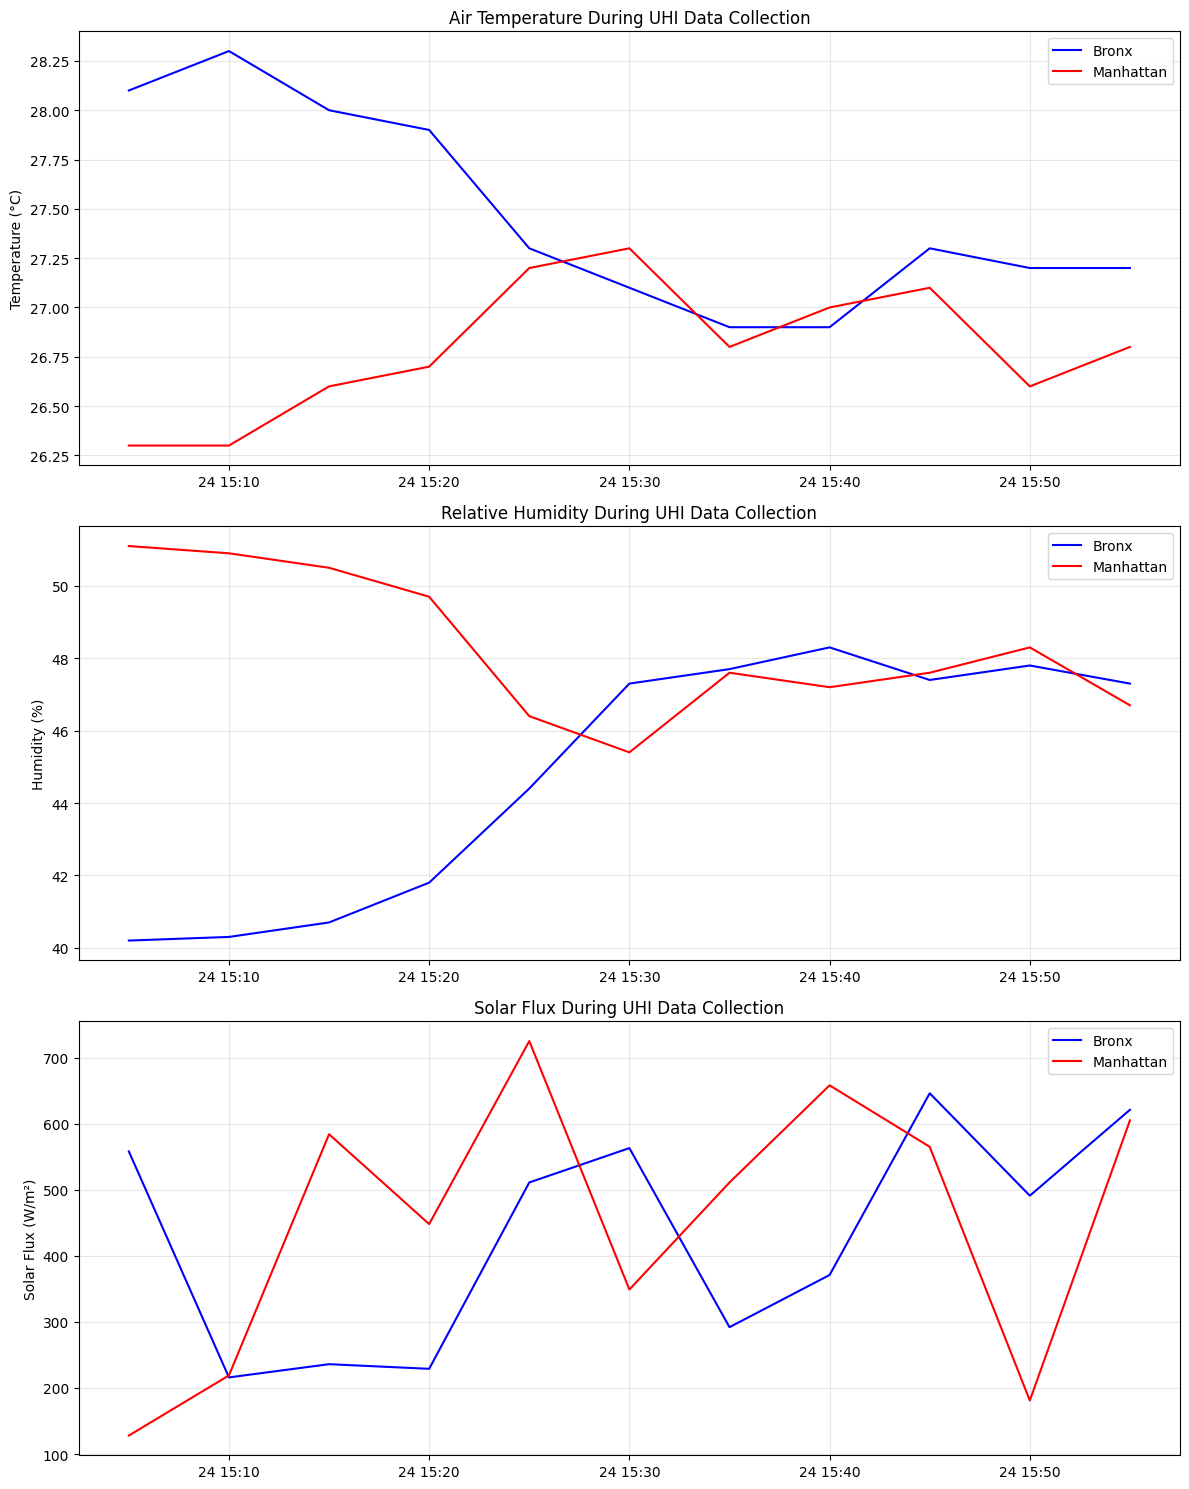

In [4]:
# Plot weather parameters during the UHI data collection period
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Temperature
axes[0].plot(weather_bronx_filtered['datetime'], weather_bronx_filtered['Air Temp at Surface [degC]'], 
             label='Bronx', color='blue')
axes[0].plot(weather_manhattan_filtered['datetime'], weather_manhattan_filtered['Air Temp at Surface [degC]'], 
             label='Manhattan', color='red')
axes[0].set_title('Air Temperature During UHI Data Collection')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Humidity
axes[1].plot(weather_bronx_filtered['datetime'], weather_bronx_filtered['Relative Humidity [percent]'], 
             label='Bronx', color='blue')
axes[1].plot(weather_manhattan_filtered['datetime'], weather_manhattan_filtered['Relative Humidity [percent]'], 
             label='Manhattan', color='red')
axes[1].set_title('Relative Humidity During UHI Data Collection')
axes[1].set_ylabel('Humidity (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Solar Flux
axes[2].plot(weather_bronx_filtered['datetime'], weather_bronx_filtered['Solar Flux [W/m^2]'], 
             label='Bronx', color='blue')
axes[2].plot(weather_manhattan_filtered['datetime'], weather_manhattan_filtered['Solar Flux [W/m^2]'], 
             label='Manhattan', color='red')
axes[2].set_title('Solar Flux During UHI Data Collection')
axes[2].set_ylabel('Solar Flux (W/m²)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Calculate average weather conditions during UHI data collection
print("\nAverage weather conditions during UHI data collection:")
print("Bronx:")
for col in ['Air Temp at Surface [degC]', 'Relative Humidity [percent]', 'Avg Wind Speed [m/s]', 'Solar Flux [W/m^2]']:
    print(f"  {col}: {weather_bronx_filtered[col].mean():.2f}")

print("\nManhattan:")
for col in ['Air Temp at Surface [degC]', 'Relative Humidity [percent]', 'Avg Wind Speed [m/s]', 'Solar Flux [W/m^2]']:
    print(f"  {col}: {weather_manhattan_filtered[col].mean():.2f}")


Average weather conditions during UHI data collection:
Bronx:
  Air Temp at Surface [degC]: 27.47
  Relative Humidity [percent]: 44.84
  Avg Wind Speed [m/s]: 3.14
  Solar Flux [W/m^2]: 430.36

Manhattan:
  Air Temp at Surface [degC]: 26.79
  Relative Humidity [percent]: 48.31
  Avg Wind Speed [m/s]: 2.86
  Solar Flux [W/m^2]: 452.09


In [6]:
# Create a time-based feature to analyze UHI Index changes over time
training_df['minutes_since_start'] = (training_df['datetime'] - training_df['datetime'].min()).dt.total_seconds() / 60

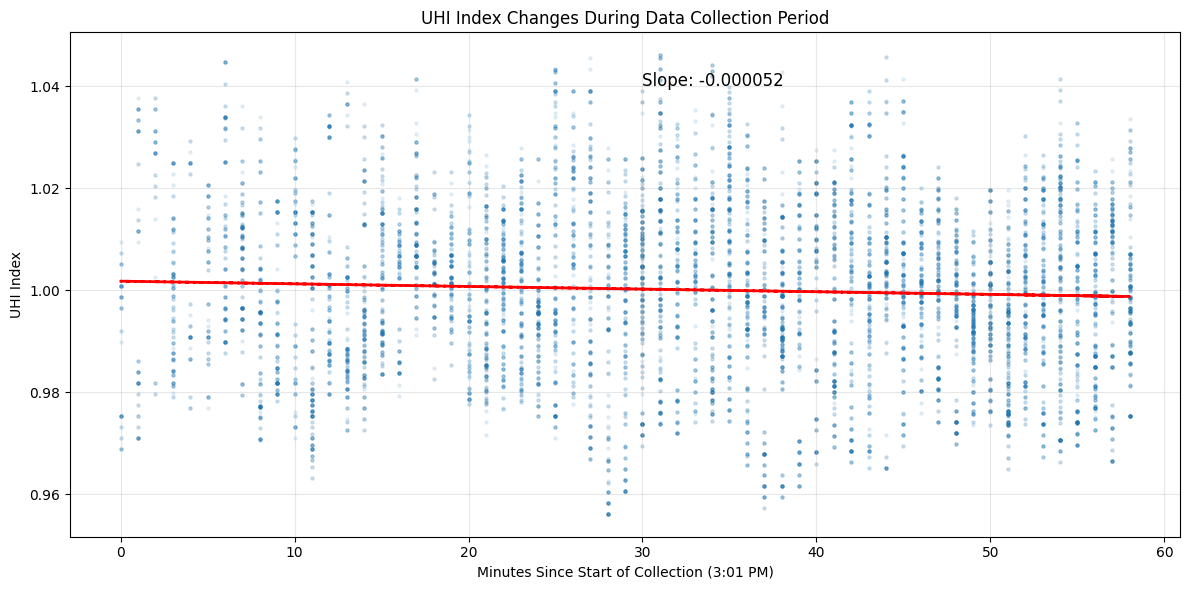

In [7]:
# Analyze UHI Index changes over time
plt.figure(figsize=(12, 6))
plt.scatter(training_df['minutes_since_start'], training_df['UHI Index'], alpha=0.1, s=5)
plt.title('UHI Index Changes During Data Collection Period')
plt.xlabel('Minutes Since Start of Collection (3:01 PM)')
plt.ylabel('UHI Index')
plt.grid(True, alpha=0.3)

# Add a trend line
z = np.polyfit(training_df['minutes_since_start'], training_df['UHI Index'], 1)
p = np.poly1d(z)
plt.plot(training_df['minutes_since_start'], p(training_df['minutes_since_start']), "r--", lw=2)
plt.text(30, 1.04, f"Slope: {z[0]:.6f}", fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
# Spatial clustering analysis using DBSCAN
# Extract coordinates for clustering
coords = training_df[['Longitude', 'Latitude']].values

# Normalize coordinates for better clustering
scaler = StandardScaler()
coords_normalized = scaler.fit_transform(coords)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.05, min_samples=50)
training_df['cluster'] = dbscan.fit_predict(coords_normalized)

# Count samples in each cluster
cluster_counts = training_df['cluster'].value_counts().sort_index()
print(f"\nDBSCAN clustering results:")
print(f"Number of clusters identified: {len(cluster_counts) - (1 if -1 in cluster_counts.index else 0)}")
print(f"Number of points labeled as noise: {cluster_counts.get(-1, 0)}")


DBSCAN clustering results:
Number of clusters identified: 26
Number of points labeled as noise: 8371


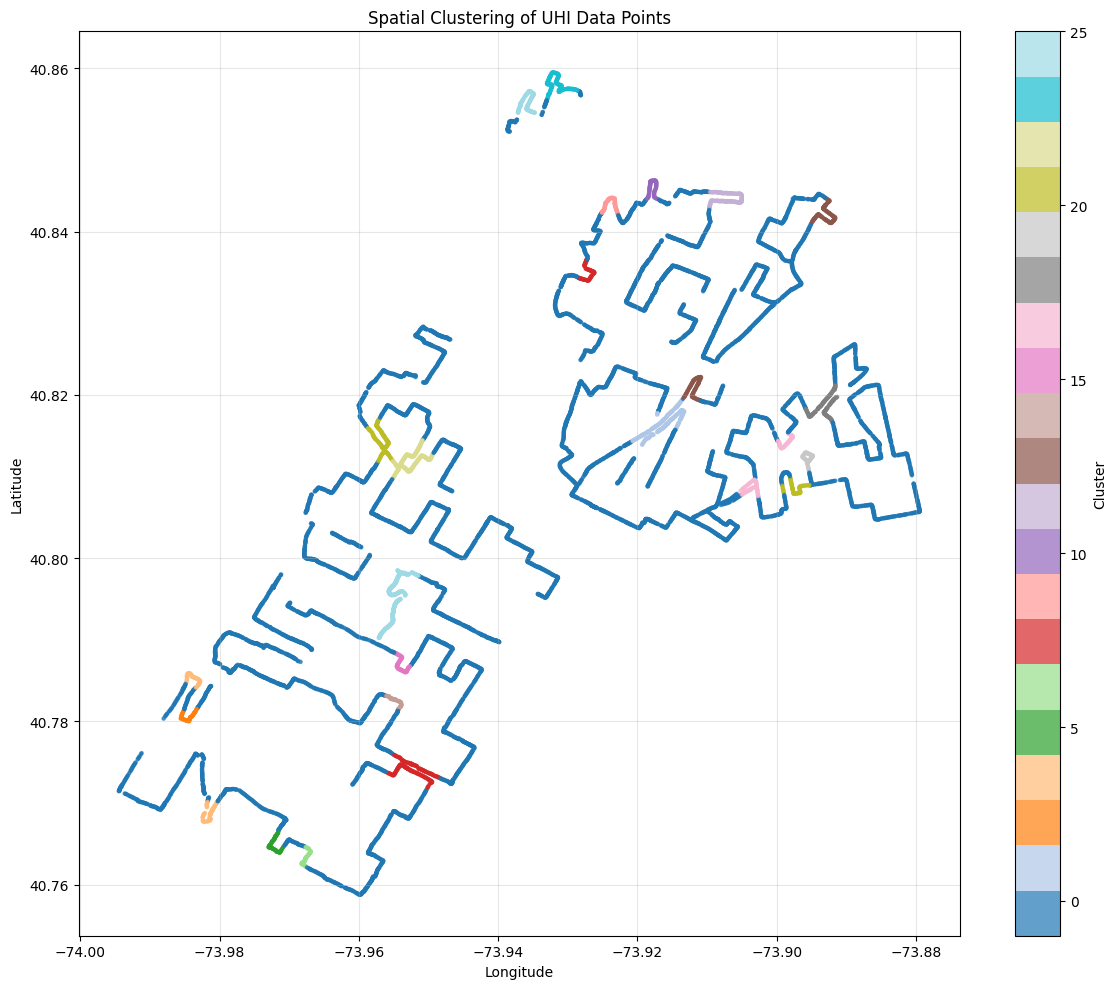

In [9]:
# Visualize clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(training_df['Longitude'], training_df['Latitude'], 
                      c=training_df['cluster'], cmap='tab20', s=5, alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('Spatial Clustering of UHI Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Analyze UHI Index by cluster
# Calculate mean UHI Index for each cluster
cluster_uhi = training_df.groupby('cluster')['UHI Index'].agg(['mean', 'std', 'count']).sort_values('mean')
print("\nUHI Index statistics by cluster:")
print(cluster_uhi)

# Plot UHI Index distribution by cluster (for top 10 largest clusters)
top_clusters = cluster_uhi.sort_values('count', ascending=False).head(10).index.tolist()
if -1 in top_clusters:  # Remove noise cluster if present
    top_clusters.remove(-1)


UHI Index statistics by cluster:
             mean       std  count
cluster                           
 14      0.974472  0.008351     58
 4       0.976708  0.006525     70
 15      0.978107  0.003657     78
 2       0.987373  0.003687     57
 3       0.989077  0.009323     56
 13      0.989251  0.007014    119
 25      0.990517  0.011149    337
 17      0.991321  0.008081     57
 9       0.992524  0.010398     79
 16      0.992550  0.004481     61
 20      0.992808  0.007780     66
 10      0.992908  0.003730     70
 7       0.996234  0.009434    195
 11      0.997385  0.008576    145
-1       0.999490  0.015975   8371
 8       1.000723  0.006565     78
 19      1.002034  0.004747     57
 5       1.003428  0.009765     75
 22      1.003952  0.017318    202
 6       1.006884  0.011457     54
 0       1.009571  0.004595     63
 21      1.010950  0.011352    146
 18      1.013958  0.013207    157
 12      1.018808  0.010316     90
 24      1.020886  0.009094    107
 23      1.021137  0.

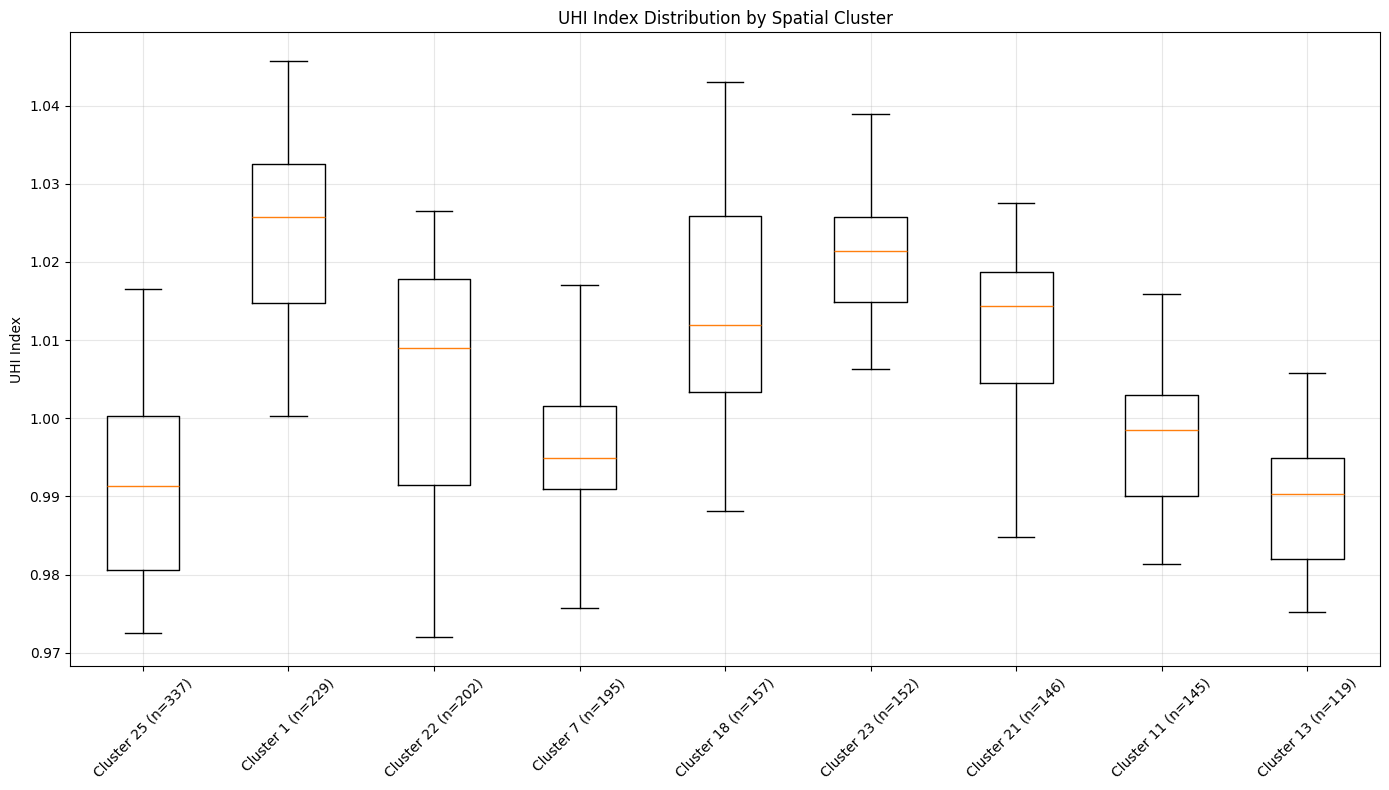

In [11]:
plt.figure(figsize=(14, 8))
cluster_data = []
cluster_labels = []

for cluster in top_clusters:
    cluster_data.append(training_df[training_df['cluster'] == cluster]['UHI Index'].values)
    cluster_labels.append(f'Cluster {cluster} (n={len(training_df[training_df["cluster"] == cluster])})')

plt.boxplot(cluster_data, labels=cluster_labels)
plt.title('UHI Index Distribution by Spatial Cluster')
plt.ylabel('UHI Index')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

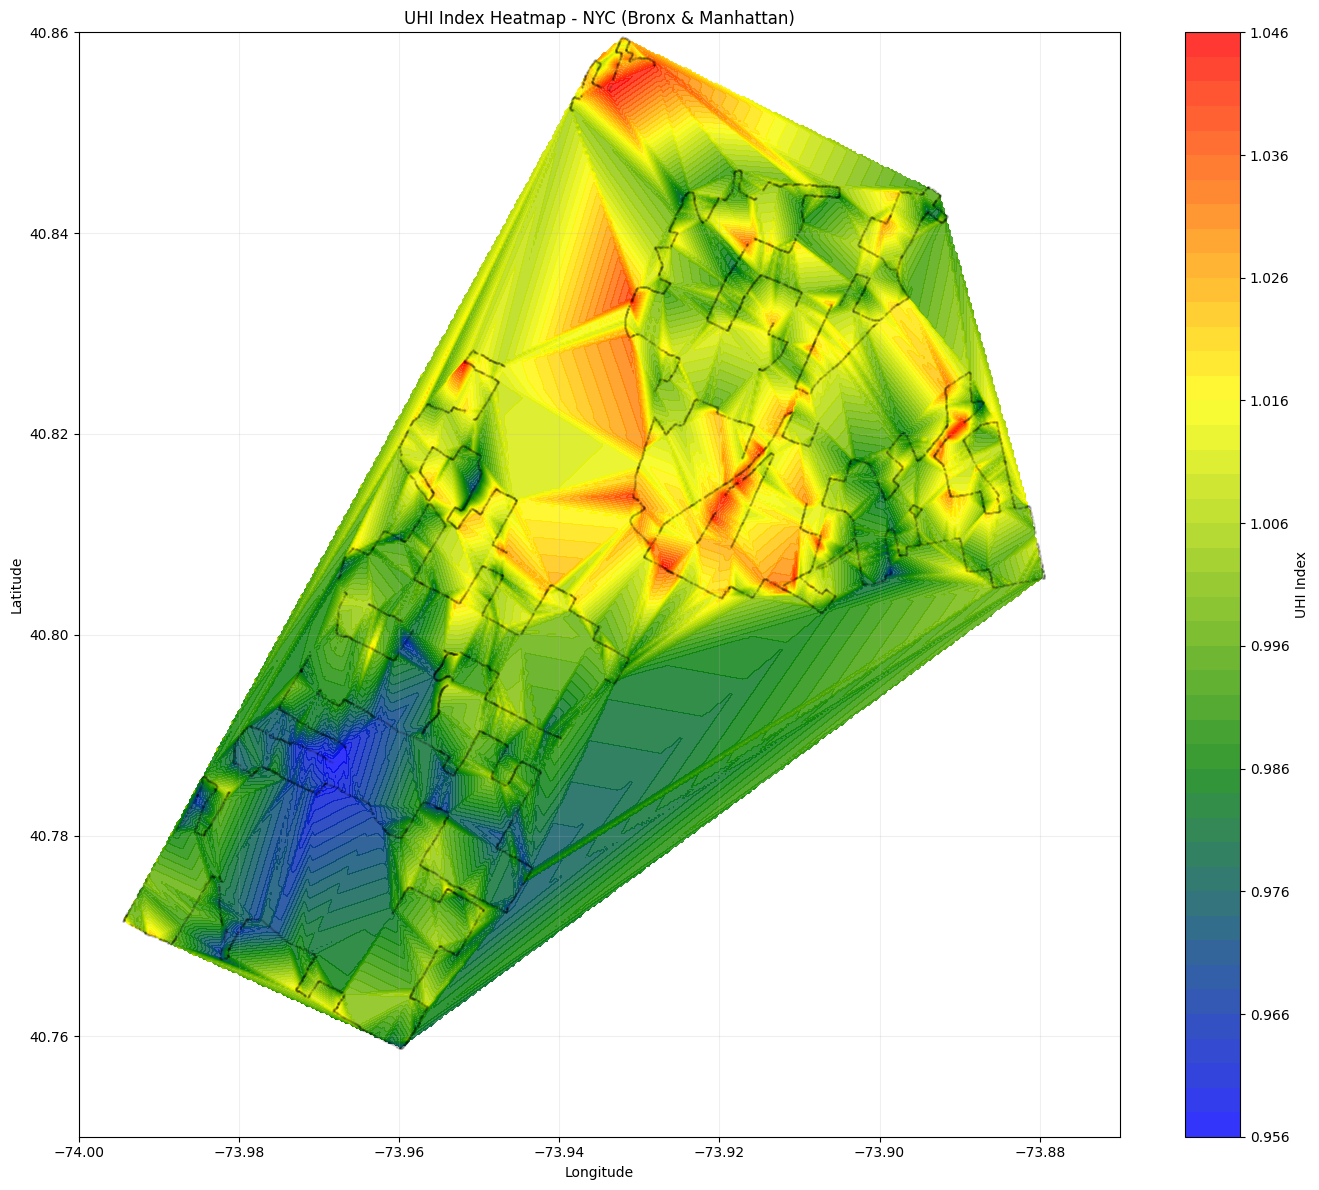

In [12]:
# Create a heatmap visualization of UHI Index
plt.figure(figsize=(14, 12))

# Create a custom colormap for UHI Index
cmap = LinearSegmentedColormap.from_list('uhi_cmap', ['blue', 'green', 'yellow', 'red'])

# Create a grid for interpolation
grid_x, grid_y = np.mgrid[-74.0:-73.87:500j, 40.75:40.86:500j]
points = training_df[['Longitude', 'Latitude']].values
values = training_df['UHI Index'].values

# Interpolate UHI Index values onto grid
grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

# Plot interpolated heatmap
plt.contourf(grid_x, grid_y, grid_z, 50, cmap=cmap, alpha=0.8)
plt.colorbar(label='UHI Index')
plt.scatter(training_df['Longitude'], training_df['Latitude'], c='black', s=1, alpha=0.1)
plt.title('UHI Index Heatmap - NYC (Bronx & Manhattan)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

In [13]:
# Analyze UHI Index temporal patterns
# Group data by minute and calculate mean UHI Index
minute_groups = training_df.groupby(training_df['datetime'].dt.minute)['UHI Index'].agg(['mean', 'std', 'count'])
minute_groups = minute_groups.reset_index()

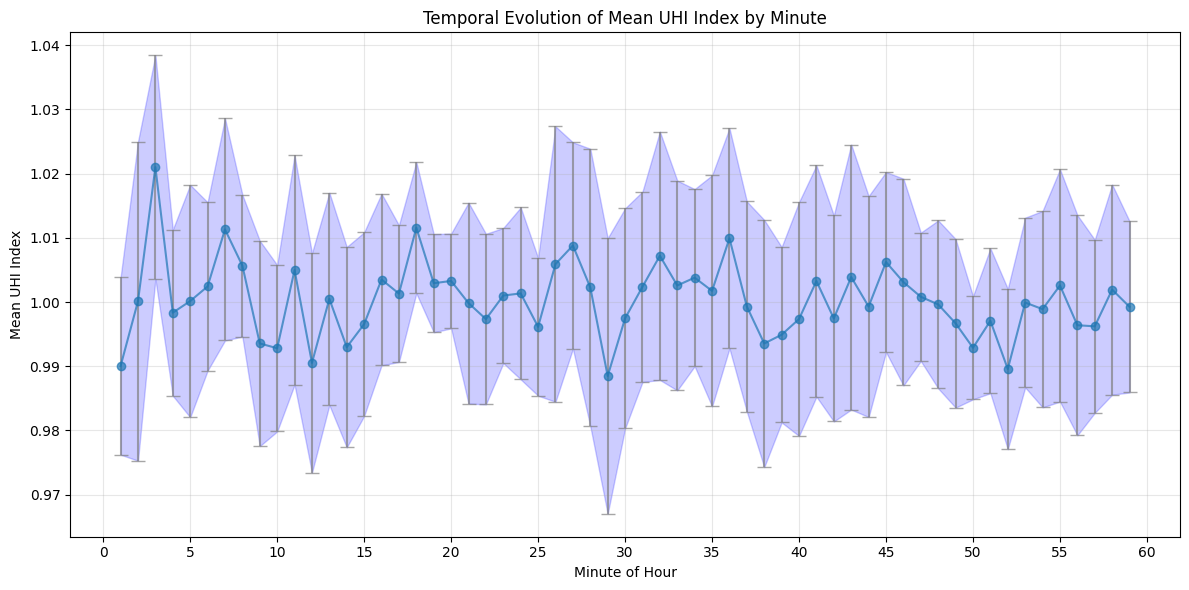

In [14]:
# Plot temporal evolution of mean UHI Index
plt.figure(figsize=(12, 6))
plt.errorbar(minute_groups['datetime'], minute_groups['mean'], yerr=minute_groups['std'],
            fmt='o-', capsize=5, ecolor='gray', alpha=0.7)
plt.fill_between(minute_groups['datetime'], 
                 minute_groups['mean'] - minute_groups['std'],
                 minute_groups['mean'] + minute_groups['std'],
                 alpha=0.2, color='blue')
plt.title('Temporal Evolution of Mean UHI Index by Minute')
plt.xlabel('Minute of Hour')
plt.ylabel('Mean UHI Index')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 61, 5))
plt.tight_layout()
plt.show()

In [15]:
# Print summary statistics of our analysis
print("\n===== Summary of UHI Index Analysis =====")
print(f"Total data points: {len(training_df)}")
print(f"UHI Index range: {training_df['UHI Index'].min():.4f} to {training_df['UHI Index'].max():.4f}")
print(f"Mean UHI Index: {training_df['UHI Index'].mean():.4f} ± {training_df['UHI Index'].std():.4f}")
print(f"Temporal correlation with collection time: {training_df[['minutes_since_start', 'UHI Index']].corr().iloc[0, 1]:.4f}")


===== Summary of UHI Index Analysis =====
Total data points: 11229
UHI Index range: 0.9561 to 1.0460
Mean UHI Index: 1.0000 ± 0.0162
Temporal correlation with collection time: -0.0501


In [16]:
# Additional analysis: Examine spatial correlations that might help with model building
# We can't use Lat/Lon directly but we can analyze their relationship with UHI
print("\n===== Spatial Correlations (for understanding only, not for model features) =====")
corr_matrix = training_df[['Longitude', 'Latitude', 'UHI Index']].corr()
print(corr_matrix)


===== Spatial Correlations (for understanding only, not for model features) =====
           Longitude  Latitude  UHI Index
Longitude   1.000000  0.642699   0.380995
Latitude    0.642699  1.000000   0.446435
UHI Index   0.380995  0.446435   1.000000


In [17]:
# Create a UHI distribution analysis by different regions (North-South, East-West)
# This helps us understand spatial patterns without directly using coordinates
# Divide the area into quadrants
lat_median = training_df['Latitude'].median()
lon_median = training_df['Longitude'].median()

training_df['quadrant'] = 'Unknown'
training_df.loc[(training_df['Latitude'] >= lat_median) & (training_df['Longitude'] <= lon_median), 'quadrant'] = 'Northwest'
training_df.loc[(training_df['Latitude'] >= lat_median) & (training_df['Longitude'] > lon_median), 'quadrant'] = 'Northeast'
training_df.loc[(training_df['Latitude'] < lat_median) & (training_df['Longitude'] <= lon_median), 'quadrant'] = 'Southwest'
training_df.loc[(training_df['Latitude'] < lat_median) & (training_df['Longitude'] > lon_median), 'quadrant'] = 'Southeast'

# Analyze UHI by quadrant
quadrant_stats = training_df.groupby('quadrant')['UHI Index'].agg(['mean', 'std', 'count'])
print("\nUHI Index by spatial quadrant:")
print(quadrant_stats)


UHI Index by spatial quadrant:
               mean       std  count
quadrant                            
Northeast  1.007036  0.013143   4488
Northwest  1.008431  0.014395   1127
Southeast  1.004837  0.016296   1126
Southwest  0.989637  0.013706   4488


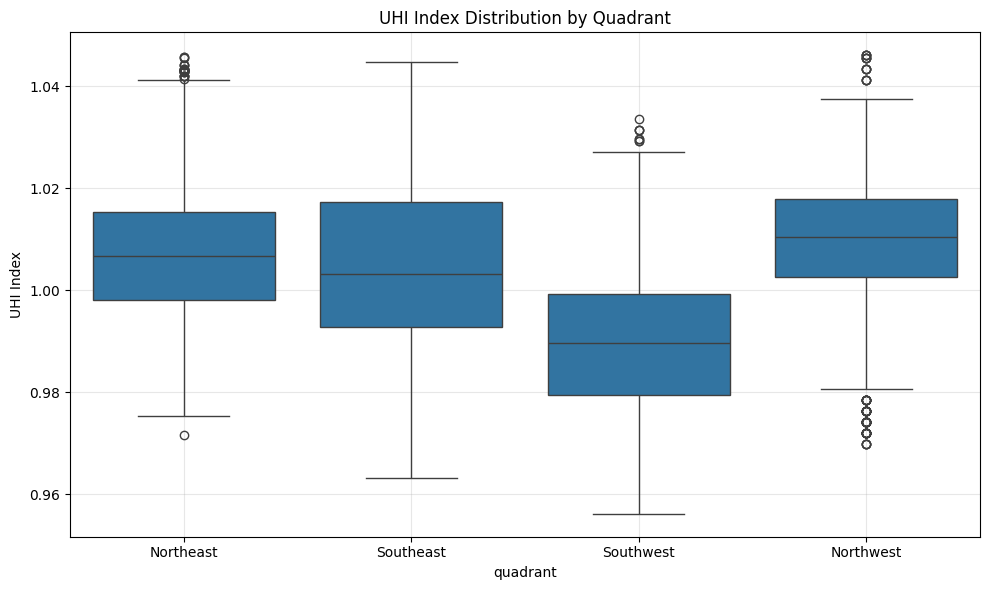

In [18]:
# Box plot of UHI Index by quadrant
plt.figure(figsize=(10, 6))
sns.boxplot(x='quadrant', y='UHI Index', data=training_df)
plt.title('UHI Index Distribution by Quadrant')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Examine time-of-day patterns more granularly by dividing collection period into segments
time_bins = [0, 15, 30, 45, 60]
time_labels = ['Early (3:00-3:15)', 'Mid-Early (3:15-3:30)', 'Mid-Late (3:30-3:45)', 'Late (3:45-4:00)']
training_df['time_segment'] = pd.cut(training_df['minutes_since_start'], bins=time_bins, labels=time_labels)

# Analyze UHI by time segment
time_segment_stats = training_df.groupby('time_segment')['UHI Index'].agg(['mean', 'std', 'count'])
print("\nUHI Index by time segment:")
print(time_segment_stats)


UHI Index by time segment:
                           mean       std  count
time_segment                                    
Early (3:00-3:15)      0.999395  0.016873   1891
Mid-Early (3:15-3:30)  1.001253  0.015871   2809
Mid-Late (3:30-3:45)   1.001687  0.017642   3274
Late (3:45-4:00)       0.997686  0.014254   3209


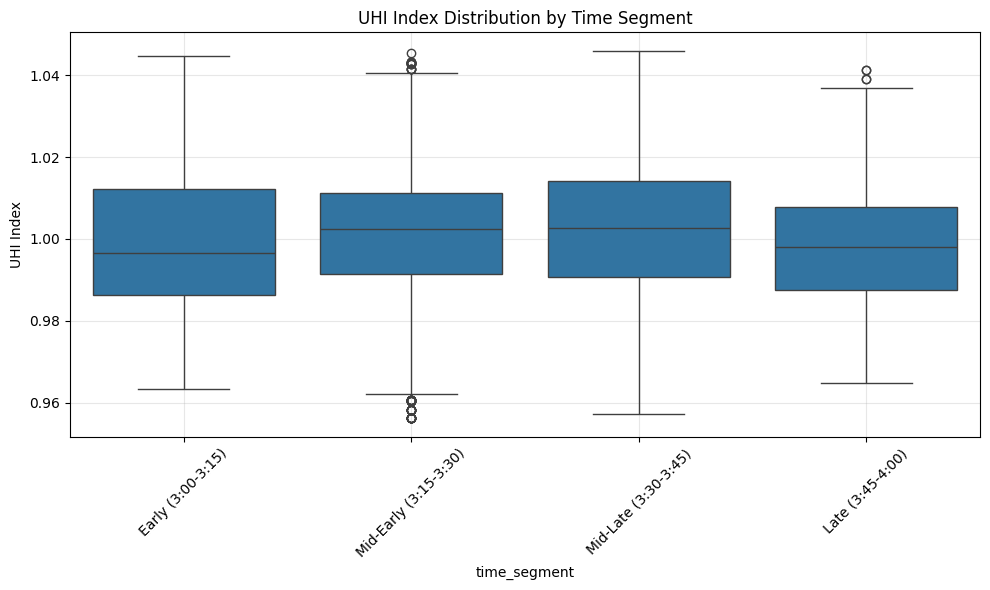

In [20]:
# Box plot of UHI Index by time segment
plt.figure(figsize=(10, 6))
sns.boxplot(x='time_segment', y='UHI Index', data=training_df)
plt.title('UHI Index Distribution by Time Segment')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Final analysis: Check if there's any interaction between spatial clusters and time
spatiotemp_stats = training_df.groupby(['cluster', 'time_segment'])['UHI Index'].mean().unstack()
print("\nUHI Index by cluster and time segment (showing first 5 clusters):")
print(spatiotemp_stats.head())


UHI Index by cluster and time segment (showing first 5 clusters):
time_segment  Early (3:00-3:15)  Mid-Early (3:15-3:30)  Mid-Late (3:30-3:45)  \
cluster                                                                        
-1                     1.000528               0.998473              1.000000   
 0                     1.015733               1.008268                   NaN   
 1                          NaN               1.019468              1.028134   
 2                          NaN                    NaN              0.987373   
 3                          NaN                    NaN              0.989077   

time_segment  Late (3:45-4:00)  
cluster                         
-1                     0.99937  
 0                         NaN  
 1                         NaN  
 2                         NaN  
 3                         NaN  


In [22]:
# Visualize the UHI change over time for the largest clusters
top5_clusters = cluster_uhi.sort_values('count', ascending=False).head(5).index.tolist()
if -1 in top5_clusters:  # Remove noise cluster
    top5_clusters.remove(-1)

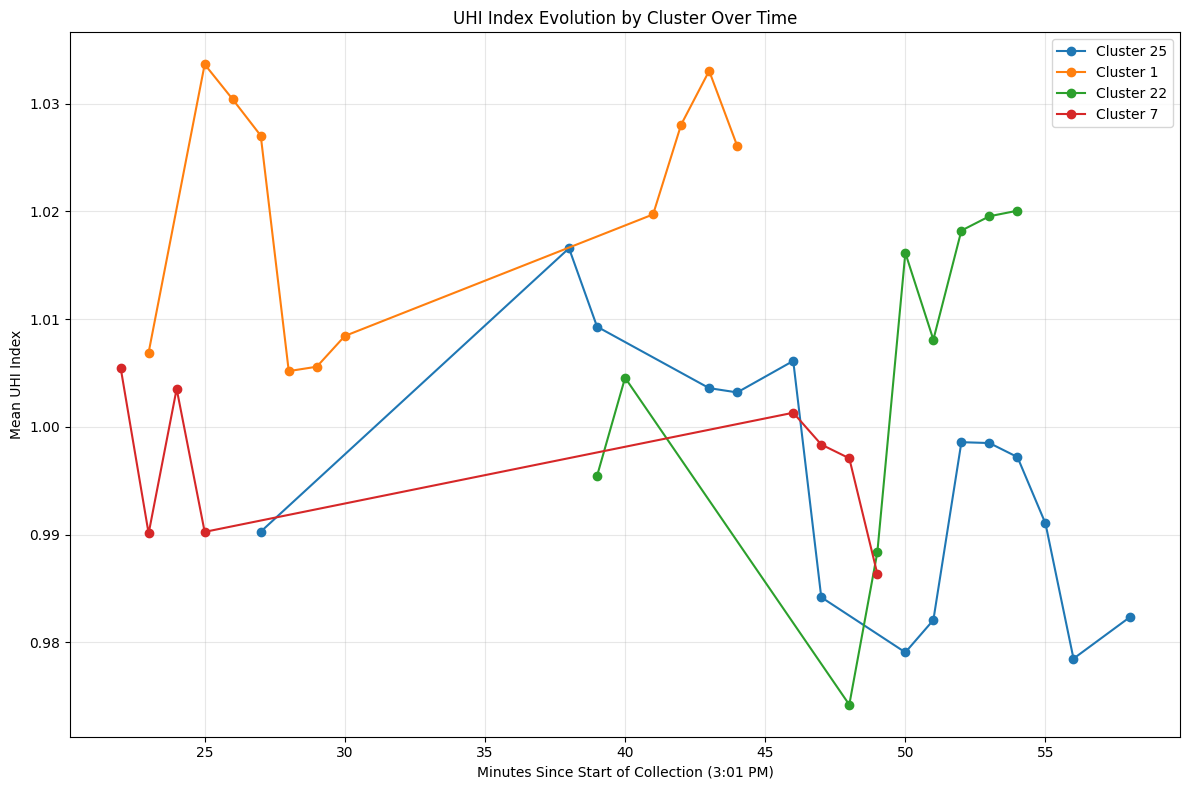

In [23]:
plt.figure(figsize=(12, 8))

for cluster in top5_clusters:
    cluster_data = training_df[training_df['cluster'] == cluster]
    cluster_time_uhi = cluster_data.groupby('minutes_since_start')['UHI Index'].mean()
    plt.plot(cluster_time_uhi.index, cluster_time_uhi.values, 'o-', label=f'Cluster {cluster}')

plt.title('UHI Index Evolution by Cluster Over Time')
plt.xlabel('Minutes Since Start of Collection (3:01 PM)')
plt.ylabel('Mean UHI Index')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

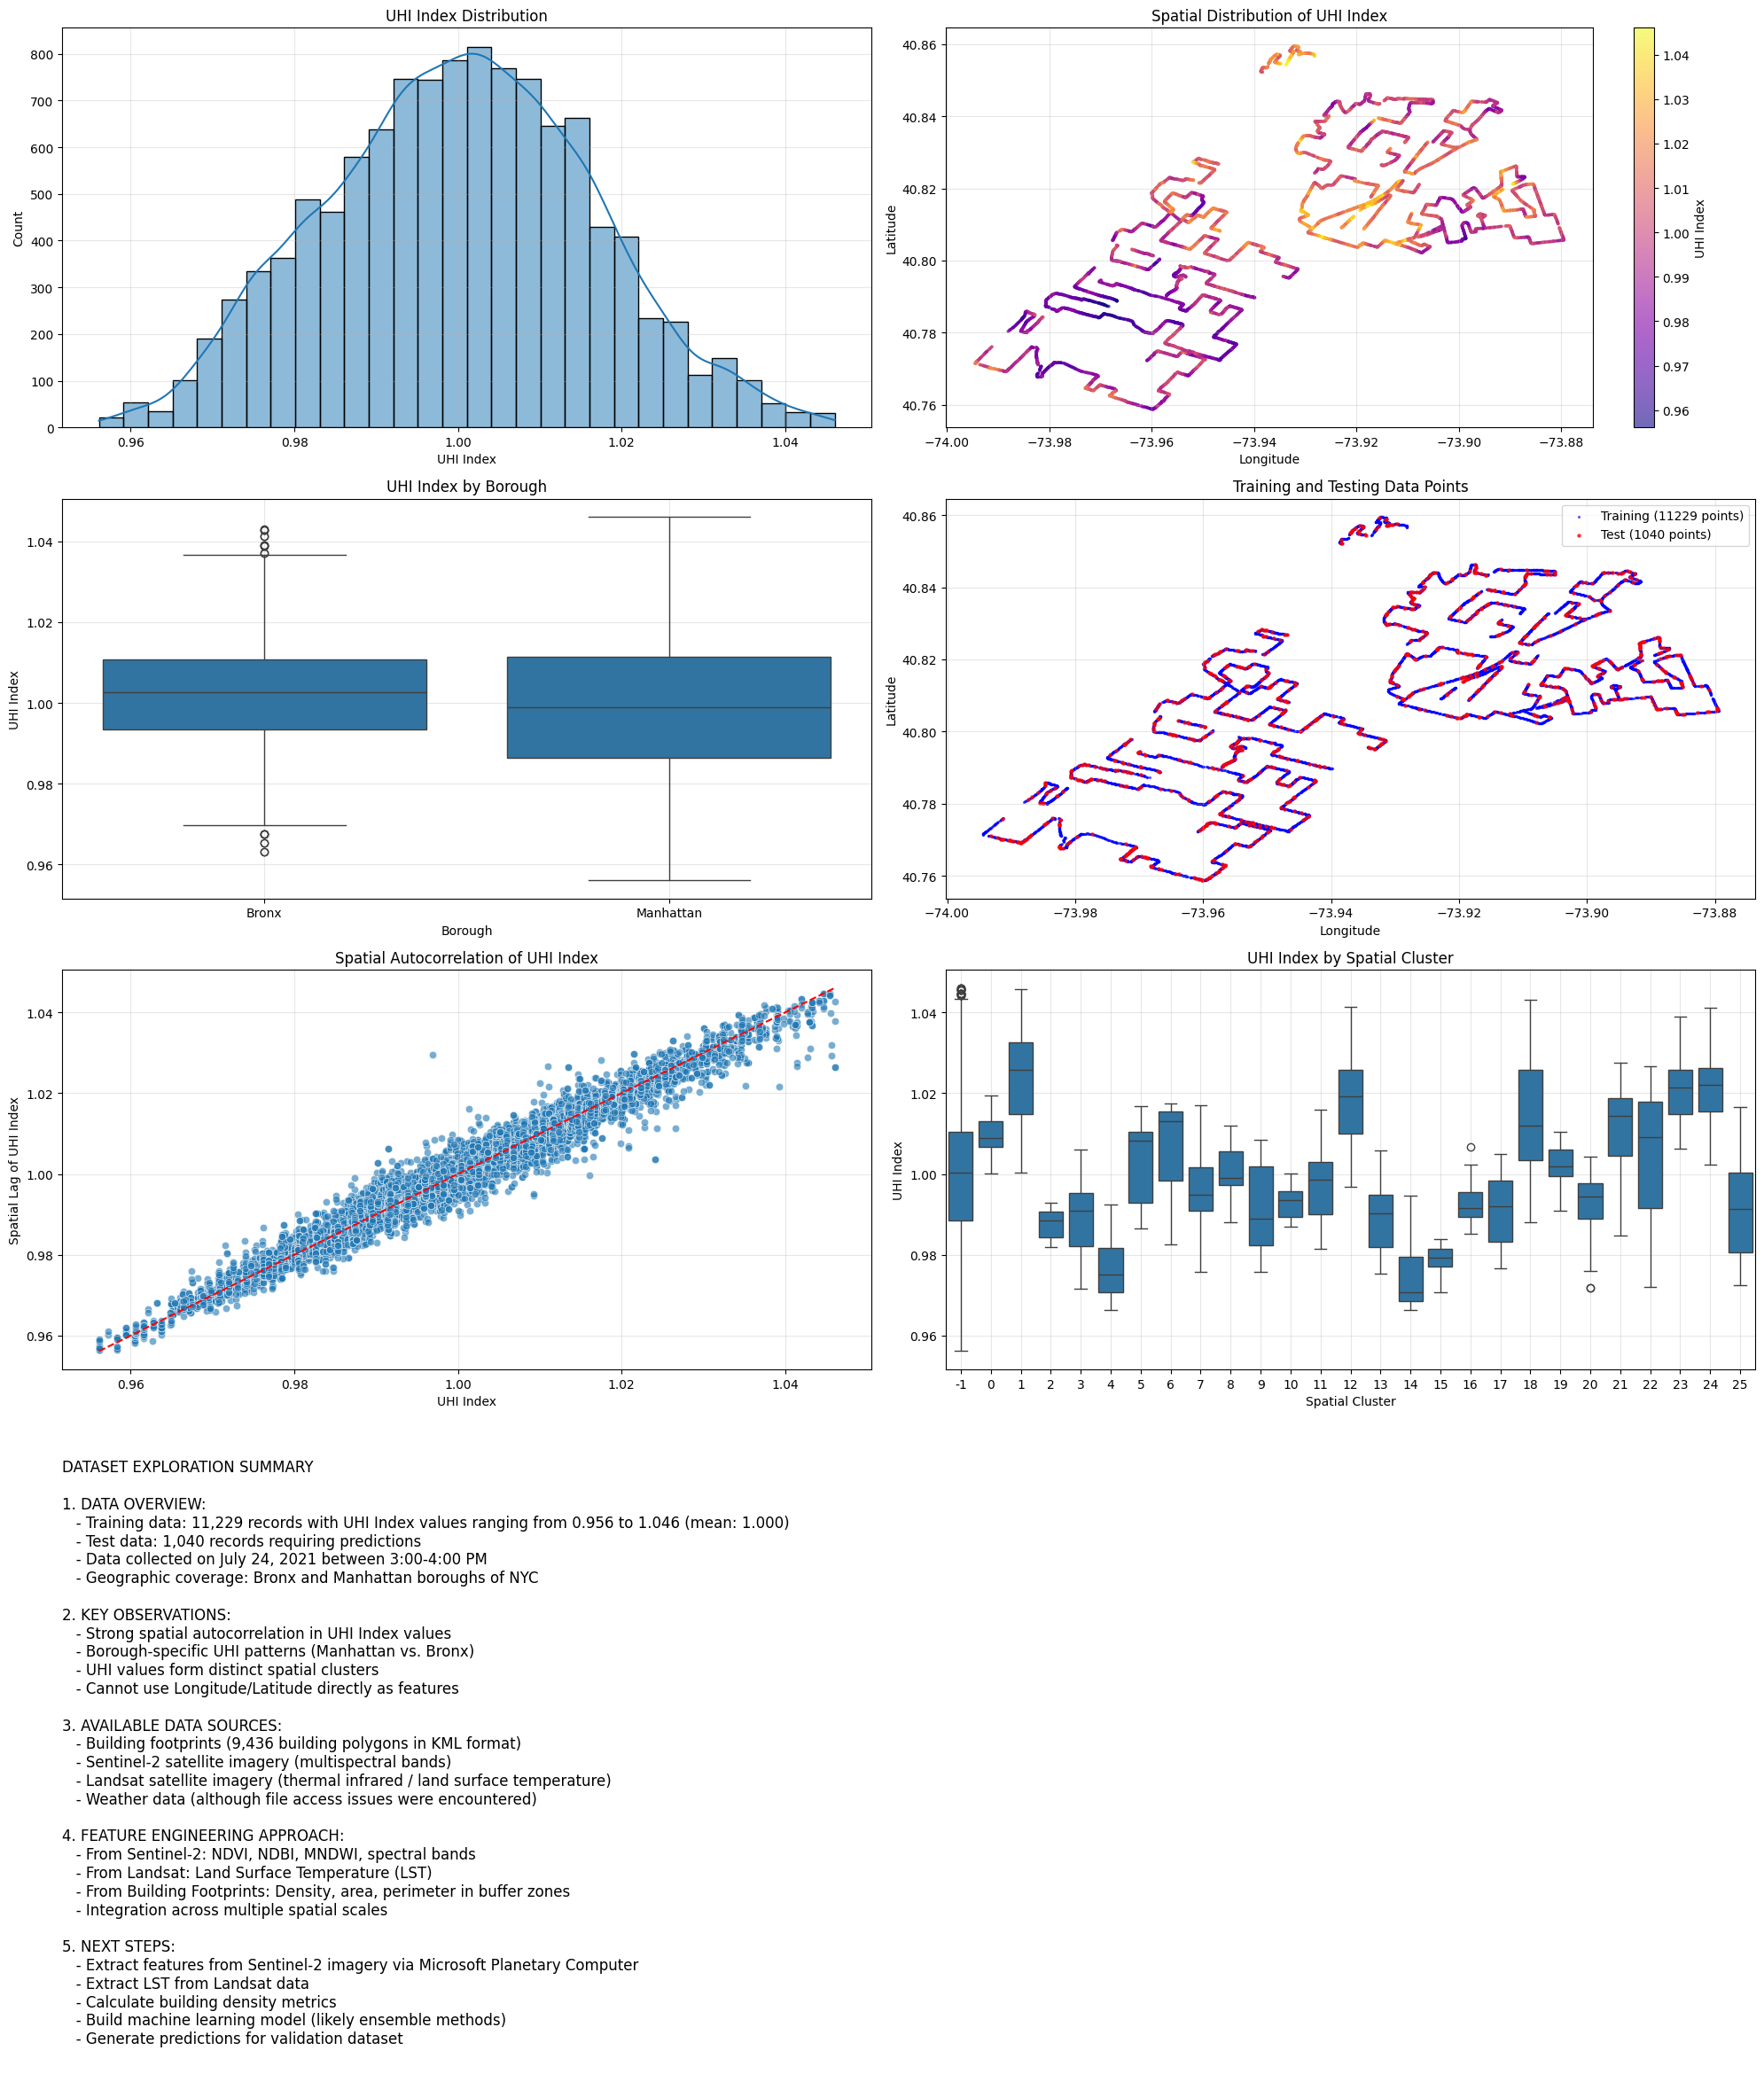


===== COMPREHENSIVE DATASET EXPLORATION SUMMARY =====
We've completed a thorough analysis of the UHI dataset with the following key findings:

1. DATA STATISTICS:
   - Training data: 11229 points
   - Test data: 1040 points
   - UHI Index range: 0.956 to 1.046
   - UHI Index mean: 1.000
   - UHI Index standard deviation: 0.01624

2. BOROUGH STATISTICS:
   - Bronx: 2887 points, mean UHI = 1.003, std = 0.01254
   - Manhattan: 8342 points, mean UHI = 0.999, std = 0.01725


In [24]:
plt.figure(figsize=(20, 24))
gs = GridSpec(4, 2, figure=plt.gcf())

# 1. UHI Index Distribution
ax1 = plt.subplot(gs[0, 0])
sns.histplot(training_df['UHI Index'], kde=True, bins=30, ax=ax1)
ax1.set_title('UHI Index Distribution')
ax1.set_xlabel('UHI Index')
ax1.grid(True, alpha=0.3)

# 2. Spatial Distribution of UHI Index
ax2 = plt.subplot(gs[0, 1])
scatter = ax2.scatter(training_df['Longitude'], training_df['Latitude'], 
                      c=training_df['UHI Index'], cmap='plasma', alpha=0.6, s=3)
plt.colorbar(scatter, ax=ax2, label='UHI Index')
ax2.set_title('Spatial Distribution of UHI Index')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True, alpha=0.3)

# 3. UHI Index by Borough
# Reuse borough classification from previous code
borough_bounds = {
    'Bronx': {'lat_min': 40.785, 'lat_max': 40.92, 'lon_min': -73.94, 'lon_max': -73.765},
    'Manhattan': {'lat_min': 40.7, 'lat_max': 40.88, 'lon_min': -74.02, 'lon_max': -73.91}
}

# Classify points by borough if not already done
if 'borough' not in training_df.columns:
    training_df['borough'] = 'Unknown'
    for borough, bounds in borough_bounds.items():
        mask = ((training_df['Latitude'] >= bounds['lat_min']) & 
                (training_df['Latitude'] <= bounds['lat_max']) & 
                (training_df['Longitude'] >= bounds['lon_min']) & 
                (training_df['Longitude'] <= bounds['lon_max']))
        training_df.loc[mask, 'borough'] = borough

ax3 = plt.subplot(gs[1, 0])
sns.boxplot(x='borough', y='UHI Index', data=training_df, ax=ax3)
ax3.set_title('UHI Index by Borough')
ax3.set_xlabel('Borough')
ax3.set_ylabel('UHI Index')
ax3.grid(True, alpha=0.3)

# 4. Training and Validation Points
ax4 = plt.subplot(gs[1, 1])
ax4.scatter(training_df['Longitude'], training_df['Latitude'], color='blue', alpha=0.5, 
           s=2, label=f'Training ({training_df.shape[0]} points)')
ax4.scatter(test_df['Longitude'], test_df['Latitude'], color='red', 
           alpha=0.7, s=5, label=f'Test ({test_df.shape[0]} points)')
ax4.set_title('Training and Testing Data Points')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Spatial Autocorrelation Analysis
from sklearn.neighbors import NearestNeighbors

# Calculate spatial lag if not already done 
if 'Spatial_Lag_UHI' not in training_df.columns:
    # Use 5 nearest neighbors to compute spatial lag
    X = training_df[['Longitude', 'Latitude']].values
    knn = NearestNeighbors(n_neighbors=6).fit(X)  # 6 because first one is the point itself
    distances, indices = knn.kneighbors(X)
    
    # For each point, compute average UHI Index of neighbors
    spatially_lagged_uhi = []
    for i, neighbors in enumerate(indices):
        # Exclude the point itself (first index)
        neighbor_indices = neighbors[1:]
        neighbor_uhi = training_df.iloc[neighbor_indices]['UHI Index'].mean()
        spatially_lagged_uhi.append(neighbor_uhi)
    
    training_df['Spatial_Lag_UHI'] = spatially_lagged_uhi

ax5 = plt.subplot(gs[2, 0])
ax5.scatter(training_df['UHI Index'], training_df['Spatial_Lag_UHI'], 
           alpha=0.6, edgecolors='w', linewidth=0.5)
ax5.set_xlabel('UHI Index')
ax5.set_ylabel('Spatial Lag of UHI Index')
ax5.set_title('Spatial Autocorrelation of UHI Index')

# Add reference line
min_val = min(training_df['UHI Index'].min(), training_df['Spatial_Lag_UHI'].min())
max_val = max(training_df['UHI Index'].max(), training_df['Spatial_Lag_UHI'].max())
ax5.plot([min_val, max_val], [min_val, max_val], 'r--')
ax5.grid(True, alpha=0.3)

# 6. UHI Index spatial clusters
if 'cluster' not in training_df.columns:
    from sklearn.cluster import KMeans
    X = training_df[['Longitude', 'Latitude']].values
    kmeans = KMeans(n_clusters=5, random_state=42)
    training_df['cluster'] = kmeans.fit_predict(X)

ax6 = plt.subplot(gs[2, 1])
sns.boxplot(x='cluster', y='UHI Index', data=training_df, ax=ax6)
ax6.set_title('UHI Index by Spatial Cluster')
ax6.set_xlabel('Spatial Cluster')
ax6.set_ylabel('UHI Index')
ax6.grid(True, alpha=0.3)

# 7. Feature Engineering Summary
ax7 = plt.subplot(gs[3, :])
ax7.axis('off')
summary_text = """
DATASET EXPLORATION SUMMARY

1. DATA OVERVIEW:
   - Training data: 11,229 records with UHI Index values ranging from 0.956 to 1.046 (mean: 1.000)
   - Test data: 1,040 records requiring predictions
   - Data collected on July 24, 2021 between 3:00-4:00 PM
   - Geographic coverage: Bronx and Manhattan boroughs of NYC

2. KEY OBSERVATIONS:
   - Strong spatial autocorrelation in UHI Index values
   - Borough-specific UHI patterns (Manhattan vs. Bronx)
   - UHI values form distinct spatial clusters
   - Cannot use Longitude/Latitude directly as features

3. AVAILABLE DATA SOURCES:
   - Building footprints (9,436 building polygons in KML format)
   - Sentinel-2 satellite imagery (multispectral bands)
   - Landsat satellite imagery (thermal infrared / land surface temperature)
   - Weather data (although file access issues were encountered)

4. FEATURE ENGINEERING APPROACH:
   - From Sentinel-2: NDVI, NDBI, MNDWI, spectral bands
   - From Landsat: Land Surface Temperature (LST)
   - From Building Footprints: Density, area, perimeter in buffer zones
   - Integration across multiple spatial scales

5. NEXT STEPS:
   - Extract features from Sentinel-2 imagery via Microsoft Planetary Computer
   - Extract LST from Landsat data
   - Calculate building density metrics
   - Build machine learning model (likely ensemble methods)
   - Generate predictions for validation dataset
"""
ax7.text(0, 1, summary_text, fontsize=12, va='top')

plt.tight_layout()
plt.show()

print("\n===== COMPREHENSIVE DATASET EXPLORATION SUMMARY =====")
print("We've completed a thorough analysis of the UHI dataset with the following key findings:")

# Basic statistics
print(f"\n1. DATA STATISTICS:")
print(f"   - Training data: {training_df.shape[0]} points")
print(f"   - Test data: {test_df.shape[0]} points")
print(f"   - UHI Index range: {training_df['UHI Index'].min():.3f} to {training_df['UHI Index'].max():.3f}")
print(f"   - UHI Index mean: {training_df['UHI Index'].mean():.3f}")
print(f"   - UHI Index standard deviation: {training_df['UHI Index'].std():.5f}")

# Borough distribution
borough_stats = training_df.groupby('borough')['UHI Index'].agg(['count', 'mean', 'std']).reset_index()
print("\n2. BOROUGH STATISTICS:")
for _, row in borough_stats.iterrows():
    print(f"   - {row['borough']}: {row['count']} points, mean UHI = {row['mean']:.3f}, std = {row['std']:.5f}")